This example shows the basic usage of getfem, on the canonical problem: solving the Laplacian, -\Delta u = f on a square, with the Dirichlet condition u = g(x) on the domain boundary \Gamma_D and the Neumann condition \frac{\partial u}{\partial\eta} = h(x) on the domain boundary \Gamma_N. You can find the py-file of this example under the name demo_laplacian.py in the directory interface/tests/python/ of the GetFEM++ distribution.

We create Mesh, MeshFem, MeshIm object and find the boundary of the domain in the same way as the previous example

In [1]:
# import basic modules
import getfem as gf
import numpy as np

# boundary names
top   = 101 # Dirichlet boundary
down  = 102 # Neumann boundary
left  = 103 # Dirichlet boundary
right = 104 # Neumann boundary

# parameters
NX = 40                             # Mesh parameter
Dirichlet_with_multipliers = True;  # Dirichlet condition with multipliers or penalization
dirichlet_coefficient = 1e10;       # Penalization coefficient

# mesh creation
m = gf.Mesh('regular_simplices', np.arange(0,1+1./NX,1./NX), np.arange(0,1+1./NX,1./NX))

# create a MeshFem for u and rhs fields of dimension 1 (i.e. a scalar field)
mfu   = gf.MeshFem(m, 1)
mfrhs = gf.MeshFem(m, 1)
# assign the P2 fem to all convexes of the both MeshFem
mfu.set_fem(gf.Fem('FEM_PK(2,2)'))
mfrhs.set_fem(gf.Fem('FEM_PK(2,2)'))

# an exact integration will be used
mim = gf.MeshIm(m, gf.Integ('IM_TRIANGLE(4)'))

# boundary selection
flst   = m.outer_faces()
fnor   = m.normal_of_faces(flst)
ttop   = abs(fnor[1,:]-1) < 1e-14
tdown  = abs(fnor[1,:]+1) < 1e-14
tleft  = abs(fnor[0,:]+1) < 1e-14
tright = abs(fnor[0,:]-1) < 1e-14
ftop   = np.compress(ttop, flst, axis=1)
fdown  = np.compress(tdown, flst, axis=1)
fleft  = np.compress(tleft, flst, axis=1)
fright = np.compress(tright, flst, axis=1)

# mark it as boundary
m.set_region(top, ftop)
m.set_region(down, fdown)
m.set_region(left, fleft)
m.set_region(right, fright)

In [2]:
# interpolate the exact solution (assuming mfu is a Lagrange fem)
g = mfu.eval('y*(y-1)*x*(x-1)+x*x*x*x*x')

# interpolate the source terms (assuming mfrhs is a Lagrange fem)
f = mfrhs.eval('-(2*(x*x+y*y)-2*x-2*y+20*x*x*x)')
h = mfrhs.eval('[y*(y-1)*(2*x-1) + 5*x*x*x*x, x*(x-1)*(2*y-1)]')

In [3]:
# model
md = gf.Model('real')

# add variable and data to model
md.add_fem_variable('u', mfu)              # main unknown
md.add_initialized_fem_data('f', mfrhs, f) # volumic source term
md.add_initialized_fem_data('g', mfrhs, g) # Dirichlet condition
md.add_initialized_fem_data('h', mfrhs, h) # Neumann condition

# bricked the problem
md.add_Laplacian_brick(mim, 'u')                             # laplacian term on u
md.add_source_term_brick(mim, 'u', 'f')                      # volumic source term
md.add_normal_source_term_brick(mim, 'u', 'h', down)         # Neumann condition
md.add_normal_source_term_brick(mim, 'u', 'h', left)         # Neumann condition

# Dirichlet condition on the top
if (Dirichlet_with_multipliers):
  md.add_Dirichlet_condition_with_multipliers(mim, 'u', mfu, top, 'g')
else:
  md.add_Dirichlet_condition_with_penalization(mim, 'u', dirichlet_coefficient, top, 'g')

# Dirichlet condition on the right
if (Dirichlet_with_multipliers):
  md.add_Dirichlet_condition_with_multipliers(mim, 'u', mfu, right, 'g')
else:
  md.add_Dirichlet_condition_with_penalization(mim, 'u', dirichlet_coefficient, right, 'g')


In [4]:
# assembly of the linear system and solve.
md.solve()

# main unknown
u  = md.variable('u')
L2error = gf.compute(mfu, u-g, 'L2 norm', mim)
H1error = gf.compute(mfu, u-g, 'H1 norm', mim)

if (H1error > 1e-3):
    print 'Error in L2 norm : ', L2error
    print 'Error in H1 norm : ', H1error
    print 'Error too large !'

# export data
mfu.export_to_pos('sol.pos', g,'Exact solution',
                             u,'Computed solution')


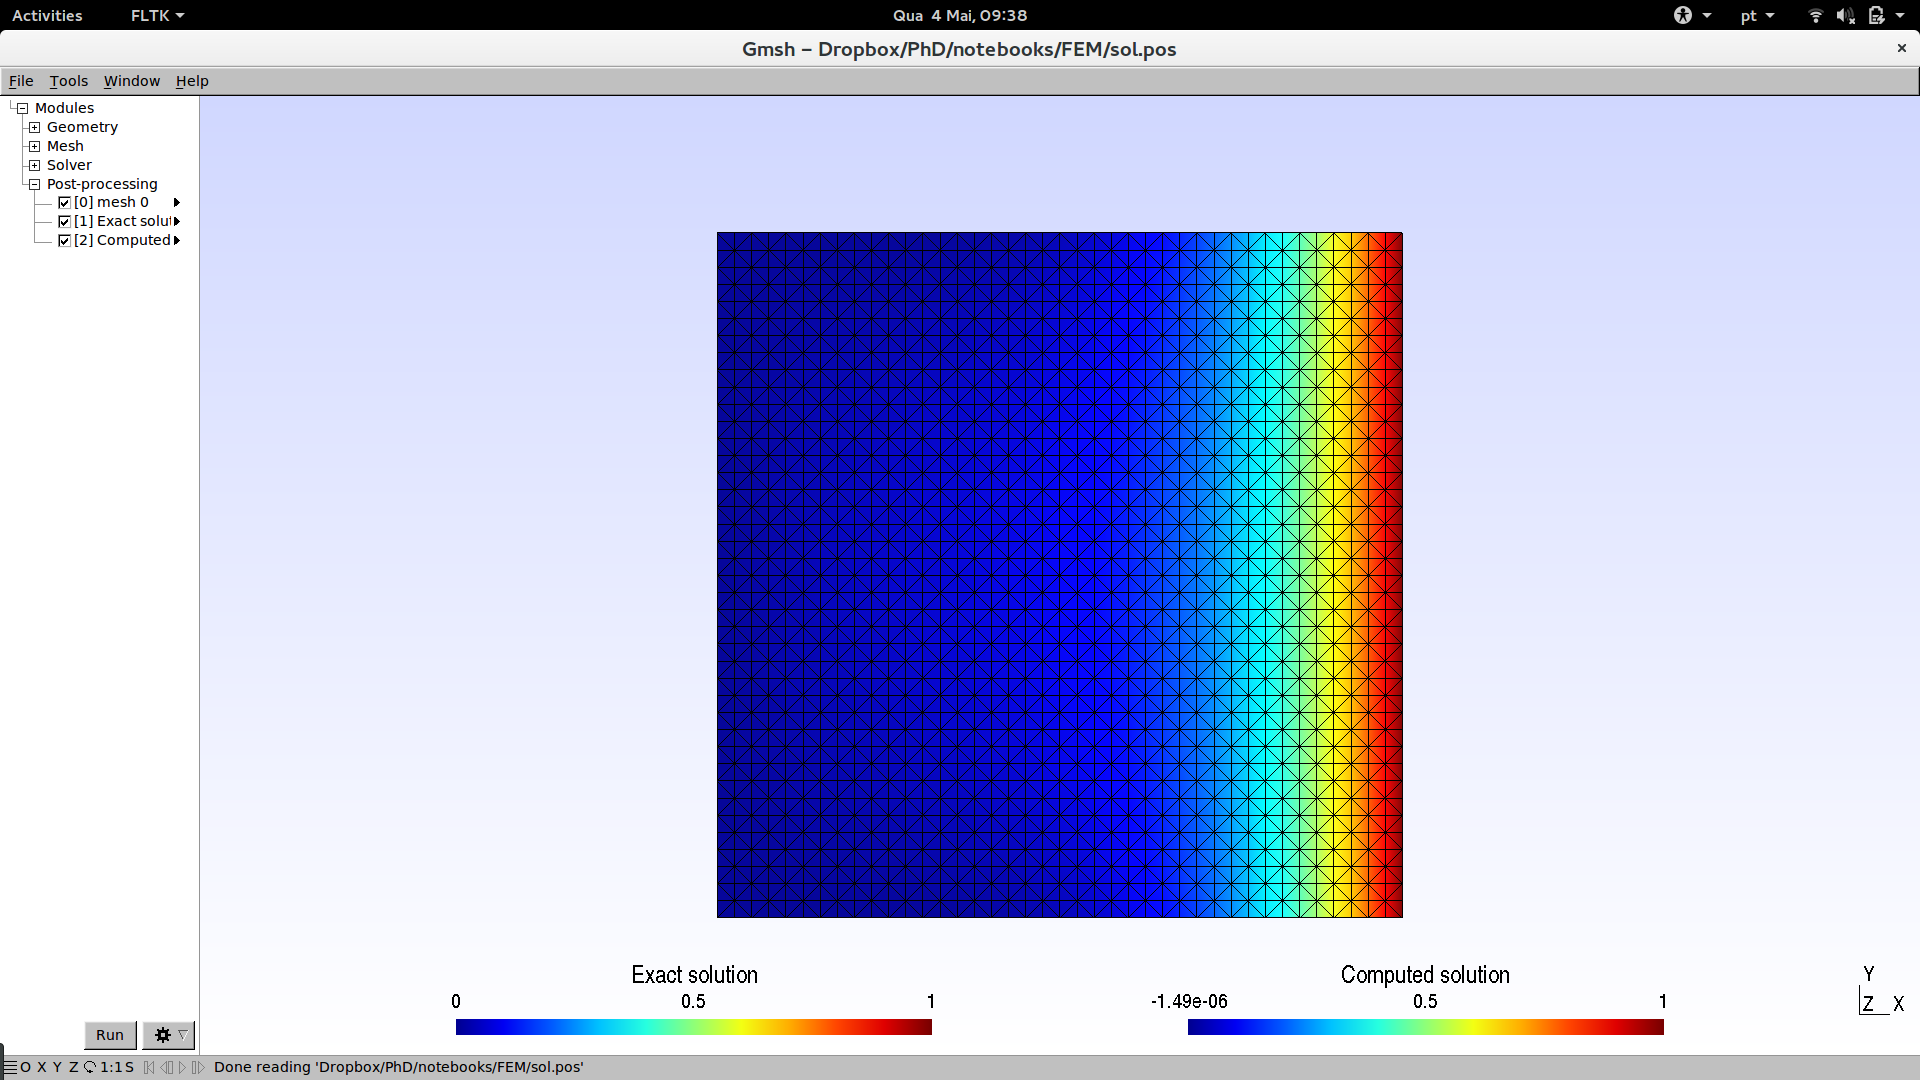

In [6]:
from IPython.display import Image
Image(filename='Screenshot from 2016-05-04 09-38-51.png', width=1000)